<div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:#2E4057;overflow:hidden"><b>Birds vs Drones Classification using Deep Learning</b></div>

<div style="background-color:#F0F8FF; padding:25px; font-size:16px;color:#2E4057; border-radius:10px">

# Project Overview

This project implements a binary image classification system to distinguish between birds and drones using deep learning techniques. The model leverages transfer learning with EfficientNetB0 architecture and provides comprehensive performance analysis including uncertainty estimation.

**Key Features:**
- Transfer learning with pre-trained EfficientNetB0
- Data augmentation for improved generalization
- Monte Carlo Dropout for uncertainty estimation
- Wilson Score statistical uncertainty analysis
- Comprehensive visualization and evaluation metrics

**Dataset:** Birds vs Drones image dataset with balanced binary classification

**Objective:** Build a robust classifier that can accurately distinguish between birds and drones while providing confidence estimates for predictions.

</div>

<div style="background-color:#F0F8FF; padding:30px; font-size:15px;color:#2E4057; border-radius:10px">


# Table of Contents

<a id="TOC"></a>
* [Setup and Library Imports](#setup)
* [Data Loading and Preprocessing](#data)
* [Data Augmentation Configuration](#augment)
* [Model Architecture](#model)
* [Model Compilation](#compile)
* [Model Training](#train)
* [Training Results Visualization](#results)
* [Model Evaluation](#eval)
* [Prediction Confidence Analysis](#confidence)
* [Uncertainty Visualization](#uncertainty)
* [Statistical Uncertainty Analysis](#statistical)
* [Wilson Score Implementation](#wilson)
* [Accuracy Uncertainty Visualization](#viz)

</div>

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">
    
<h2 id="setup">Setup and Library Imports</h2>

Setting up the environment with all necessary libraries for deep learning, data manipulation, and visualization. Random seeds are configured for reproducible results across different runs.

</div>

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.18.0
Keras version: 3.8.0


<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2 id="data">Data Loading and Preprocessing</h2>

Loading the Birds vs Drones dataset and creating train/validation/test splits. The dataset is automatically explored to understand its structure and ensure proper loading for binary classification.

</div>

In [4]:
# data_dir = './data'
data_dir = '/kaggle/input/birds-vs-drone-dataset'

print("Exploring dataset structure:")
for root, dirs, files in os.walk(data_dir):
    level = root.replace(data_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files) - 5} more files")

birds_path = os.path.join(data_dir, 'Birds')
drones_path = os.path.join(data_dir, 'Drones')

if os.path.exists(birds_path) and os.path.exists(drones_path):
    print("\nFound Birds and Drones folders!")
    actual_data_dir = data_dir
else:
    subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    print(f"\nSubdirectories found: {subdirs}")
    
    for subdir in subdirs:
        potential_path = os.path.join(data_dir, subdir)
        if (os.path.exists(os.path.join(potential_path, 'Birds')) and 
            os.path.exists(os.path.join(potential_path, 'Drones'))):
            actual_data_dir = potential_path
            print(f"Found Birds and Drones in: {actual_data_dir}")
            break
    else:
        actual_data_dir = data_dir
        print(f"Using original path: {actual_data_dir}")

train_dataset = tf.keras.utils.image_dataset_from_directory(
    actual_data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32,
    label_mode='binary'
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    actual_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32,
    label_mode='binary'
)

val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 2)
val_dataset = val_dataset.skip(val_batches // 2)

class_names = train_dataset.class_names
print("Class names:", class_names)

print(f"Training batches: {tf.data.experimental.cardinality(train_dataset)}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_dataset)}")
print(f"Test batches: {tf.data.experimental.cardinality(test_dataset)}")

Exploring dataset structure:
birds-vs-drone-dataset/
  BirdVsDrone/
    Birds/
      singleBirdinsky316.jpeg
      singleBirdinsky22.jpeg
      singleBirdinsky280.jpeg
      singleBirdinsky210.jpeg
      singleBirdinsky123.jpeg
      ... and 395 more files
    Drones/
      266.JPEG
      14.JPEG
      singleDronesinsky372.jpeg
      55.JPEG
      130.JPEG
      ... and 423 more files

Subdirectories found: ['BirdVsDrone']
Found Birds and Drones in: /kaggle/input/birds-vs-drone-dataset/BirdVsDrone
Found 826 files belonging to 2 classes.
Using 661 files for training.
Found 826 files belonging to 2 classes.
Using 165 files for validation.
Class names: ['Birds', 'Drones']
Training batches: 21
Validation batches: 3
Test batches: 3


<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2 id="augment">Data Augmentation Configuration</h2>

Implementing data augmentation techniques to improve model generalization. Random transformations include horizontal/vertical flips, rotation, and zoom operations to create diverse training samples.

</div>

In [5]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2 id="model">Model Architecture</h2>

Building a transfer learning model using EfficientNetB0 as the backbone. The architecture includes data augmentation, global average pooling, dropout for regularization, and a final dense layer for binary classification.

</div>

In [6]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2 id="compile">Model Compilation</h2>

Configuring the model for training with Adam optimizer, binary crossentropy loss, and accuracy metric. The learning rate is set to 1e-4 for stable convergence.

</div>

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2 id="train">Model Training</h2>

Training the model for 15 epochs with both training and validation datasets. The training history is stored for later analysis and visualization.

</div>

In [8]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    verbose=1
)

Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.3829 - loss: 0.7861 - val_accuracy: 0.4058 - val_loss: 0.7462
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5140 - loss: 0.7151 - val_accuracy: 0.5652 - val_loss: 0.6633
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5618 - loss: 0.6701 - val_accuracy: 0.6667 - val_loss: 0.6074
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.6941 - loss: 0.6158 - val_accuracy: 0.7101 - val_loss: 0.5887
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7088 - loss: 0.5804 - val_accuracy: 0.8406 - val_loss: 0.5255
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7369 - loss: 0.5567 - val_accuracy: 0.8116 - val_loss: 0.5213
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8040 - loss: 0.5210 - val_accuracy: 0.8261 - val_loss: 0.4993
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8129 - loss: 0.4987 - val_accuracy: 0.8261 - val_loss:

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2 id="result">Training Results Visualizatio </h2>

Visualizing training progress through accuracy and loss curves. These plots help identify overfitting, underfitting, and overall model convergence patterns.

</div>

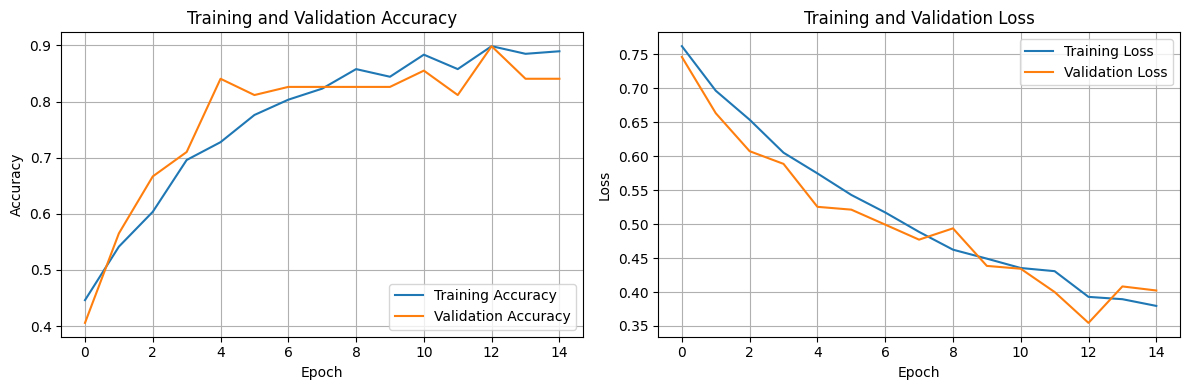

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2 id="eval">Model Evaluation</h2>

Comprehensive evaluation of model performance on test data including accuracy metrics, confusion matrix visualization, and detailed classification report.

</div>

Test accuracy: 0.8750
Test loss: 0.3638


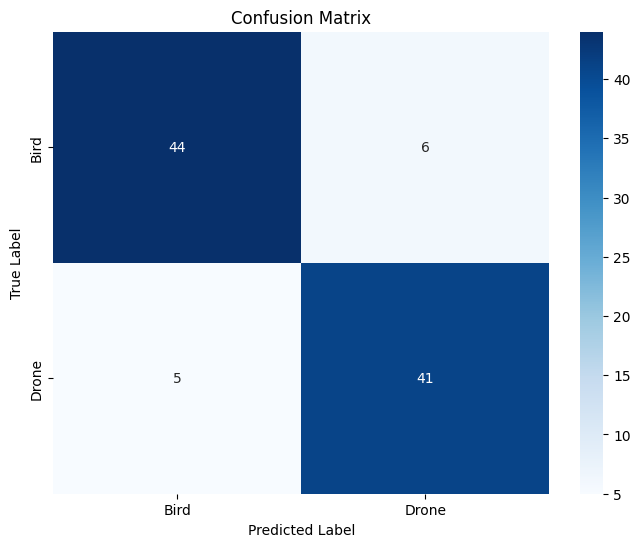


Classification Report:
              precision    recall  f1-score   support

        Bird       0.90      0.88      0.89        50
       Drone       0.87      0.89      0.88        46

    accuracy                           0.89        96
   macro avg       0.89      0.89      0.89        96
weighted avg       0.89      0.89      0.89        96



In [10]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((predictions > 0.5).astype(int).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bird', 'Drone'], 
            yticklabels=['Bird', 'Drone'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Bird', 'Drone']))

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2 id="confidence">Prediction Confidence Analysis</h2>

Analyzing prediction confidence through Monte Carlo Dropout technique. This method provides uncertainty estimates by running multiple forward passes with dropout enabled during inference.

**Note:** Confidence scores represent the model's certainty based on proximity to decision boundaries, while uncertainty measures the variability across multiple predictions.

</div>

In [12]:
def mc_predict(model, images, T=20):
    predictions = []
    for _ in range(T):
        pred = model(images, training=True)
        predictions.append(pred)
    
    return tf.stack(predictions)

test_images, test_labels = next(iter(test_dataset))

mc_predictions = mc_predict(model, test_images, T=20)

mean_predictions = tf.reduce_mean(mc_predictions, axis=0)
uncertainty = tf.math.reduce_variance(mc_predictions, axis=0)

mean_predictions = mean_predictions.numpy()
uncertainty = uncertainty.numpy()
test_labels = test_labels.numpy()

print(f"Mean prediction shape: {mean_predictions.shape}")
print(f"Uncertainty shape: {uncertainty.shape}")

Mean prediction shape: (32, 1)
Uncertainty shape: (32, 1)


<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2 id="uncertainty">Uncertainty Visualization</h2>

Visual analysis of prediction confidence and uncertainty for individual test samples. Green titles indicate correct predictions while red indicates incorrect ones.

</div>

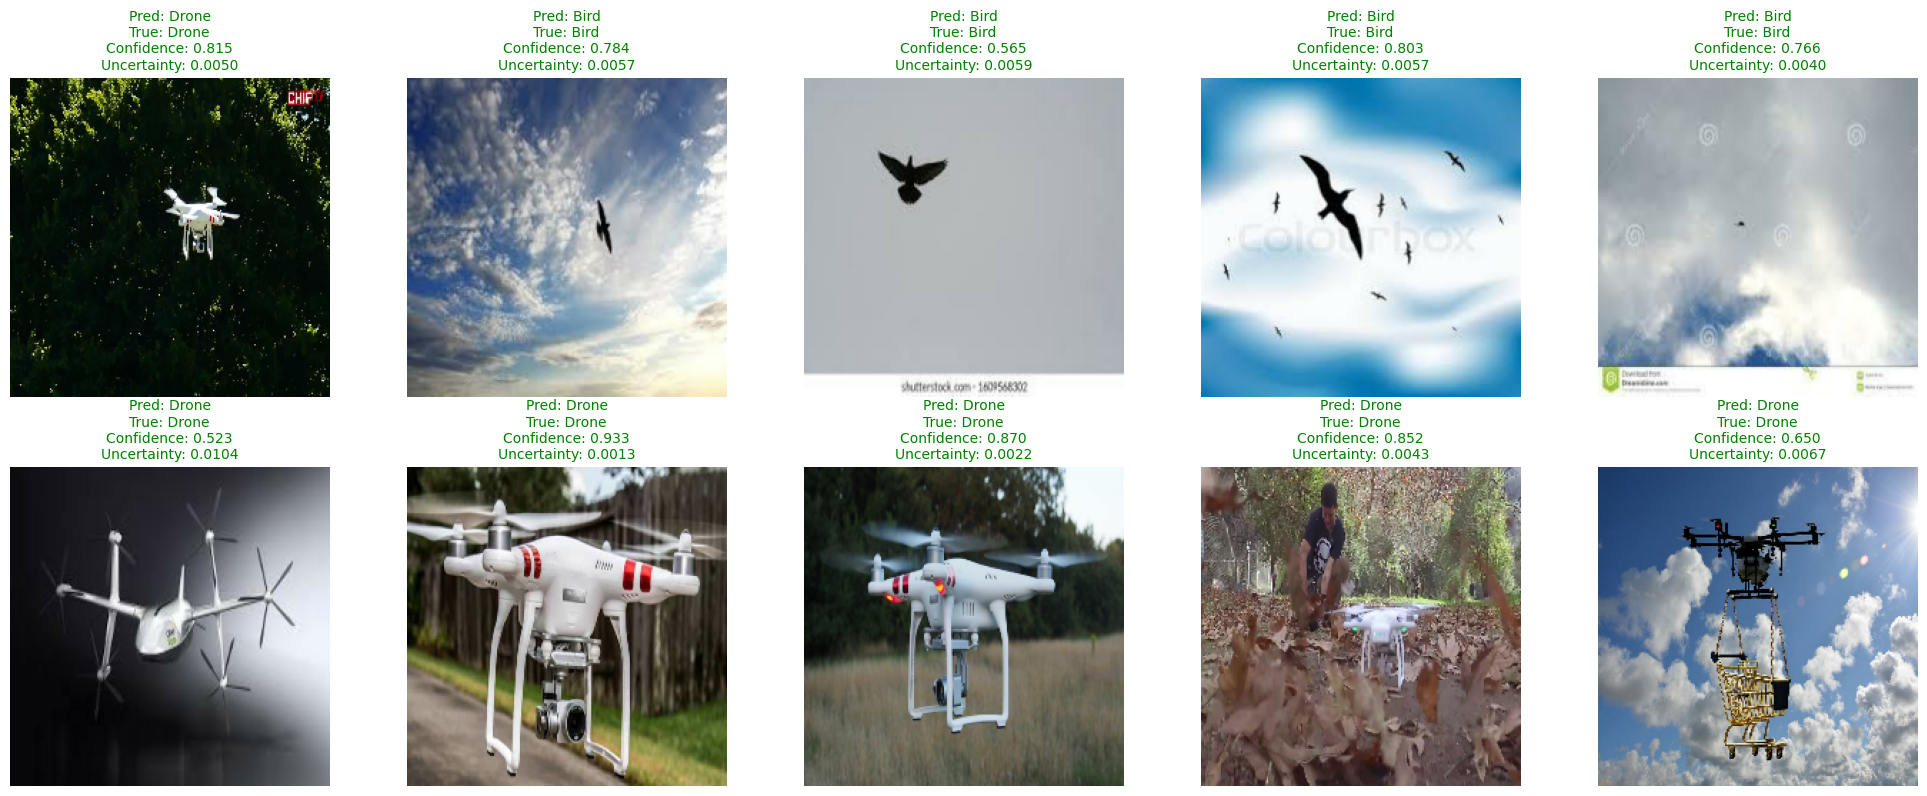

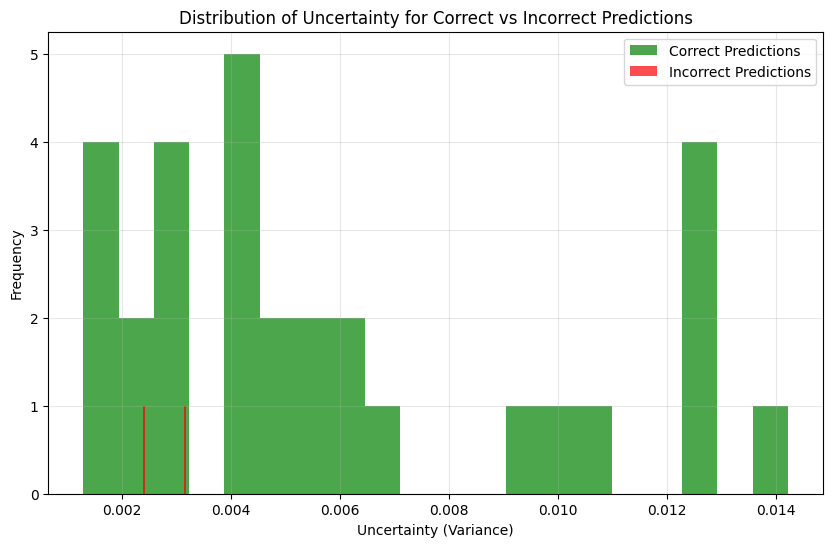

Average uncertainty for correct predictions: 0.0059
Average uncertainty for incorrect predictions: 0.0028
Total test samples: 32
Correct predictions: 30
Incorrect predictions: 2


In [13]:
plt.figure(figsize=(20, 8))

for i in range(min(10, len(test_images))):
    plt.subplot(2, 5, i + 1)
    
    plt.imshow(test_images[i].numpy().astype("uint8"))
    plt.axis('off')
    
    pred_prob = mean_predictions[i][0]
    pred_class = 'Drone' if pred_prob > 0.5 else 'Bird'
    true_class = 'Drone' if test_labels[i] == 1 else 'Bird'
    confidence = pred_prob if pred_prob > 0.5 else 1 - pred_prob
    uncertainty_score = uncertainty[i][0]
    
    is_correct = (pred_prob > 0.5) == (test_labels[i] == 1)
    title_color = 'green' if is_correct else 'red'
    
    title = f"Pred: {pred_class}\nTrue: {true_class}\nConfidence: {confidence:.3f}\nUncertainty: {uncertainty_score:.4f}"
    
    plt.title(title, color=title_color, fontsize=10)

plt.tight_layout()
plt.show()

correct_predictions = (mean_predictions.flatten() > 0.5) == (test_labels.flatten() == 1)
uncertainty_flat = uncertainty.flatten()

uncertainty_correct = uncertainty_flat[correct_predictions]
uncertainty_incorrect = uncertainty_flat[~correct_predictions]

plt.figure(figsize=(10, 6))
plt.hist(uncertainty_correct, bins=20, alpha=0.7, label='Correct Predictions', color='green')
plt.hist(uncertainty_incorrect, bins=20, alpha=0.7, label='Incorrect Predictions', color='red')
plt.xlabel('Uncertainty (Variance)')
plt.ylabel('Frequency')
plt.title('Distribution of Uncertainty for Correct vs Incorrect Predictions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Average uncertainty for correct predictions: {np.mean(uncertainty_correct):.4f}")
print(f"Average uncertainty for incorrect predictions: {np.mean(uncertainty_incorrect):.4f}")
print(f"Total test samples: {len(test_labels)}")
print(f"Correct predictions: {np.sum(correct_predictions)}")
print(f"Incorrect predictions: {np.sum(~correct_predictions)}")

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2 id="statistical">Statistical Uncertainty Analysis</h2>

Implementing statistical uncertainty analysis using Wilson Score Interval to quantify confidence in model accuracy estimates. This method provides reliable confidence intervals for proportions, especially with smaller sample sizes.

</div>

<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2 id="wilson">Wilson Score Implementation</h2>

Wilson Score Interval calculation for determining confidence bounds on accuracy measurements. This statistical method answers: "How confident can we be that our calculated accuracy reflects the true model performance?"

</div>

In [14]:
def wilson(p, n, z=3.29):
    if n <= 0:
        raise ValueError(f"n must be positive, got {n}")
    if not (0 <= p <= 1):
        raise ValueError(f"p must be between 0 and 1, got {p}")
    
    denominator = 1 + z**2/n
    centre_adjusted_probability = p + z**2 / (2*n)
    
    variance_term = (p*(1 - p) + z**2 / (4*n)) / n
    
    if variance_term < 0:
        print(f"Warning: variance_term is negative: {variance_term}")
        variance_term = abs(variance_term)
    
    adjusted_standard_deviation = sqrt(variance_term)
    
    lower_bound = (centre_adjusted_probability - z*adjusted_standard_deviation) / denominator
    upper_bound = (centre_adjusted_probability + z*adjusted_standard_deviation) / denominator
    
    return (lower_bound, upper_bound)

class_to_analyze = 1
class_name = class_names[class_to_analyze]

indices = np.where(y_true == class_to_analyze)[0]
total_class_samples = len(indices)

true_labels_class = y_true[indices]
pred_labels_class = y_pred[indices]

correct_predictions = np.sum(true_labels_class.flatten() == pred_labels_class)
incorrect_predictions = total_class_samples - correct_predictions

p = correct_predictions / total_class_samples

lower_bound, upper_bound = wilson(p, total_class_samples)

print(f"--- Uncertainty Analysis for '{class_name}' Class ---")
print(f"Total '{class_name}' images in test set: {total_class_samples}")
print(f"Correctly predicted: {correct_predictions}")
print(f"Incorrectly predicted: {incorrect_predictions}")
print(f"Observed Accuracy (p): {p:.4f}")
print("\n")
print(f"The 99.9% Wilson Score Confidence Interval for the accuracy is:")
print(f"({lower_bound:.4f}, {upper_bound:.4f})")
print(f"\nThis means we can be 99.9% confident that the model's true accuracy on '{class_name}'s is between {lower_bound*100:.2f}% and {upper_bound*100:.2f}%.")

--- Uncertainty Analysis for 'Drones' Class ---
Total 'Drones' images in test set: 46
Correctly predicted: 41
Incorrectly predicted: 5
Observed Accuracy (p): 0.8913


The 99.9% Wilson Score Confidence Interval for the accuracy is:
(0.6618, 0.9717)

This means we can be 99.9% confident that the model's true accuracy on 'Drones's is between 66.18% and 97.17%.


<div style="background-color:#F0F8FF; padding:20px; font-size:14px;color:#2E4057; border-radius:10px">

<h2 id="viz">Accuracy Uncertainty Visualization</h2>

Final visualization showing the model's accuracy estimate with statistical uncertainty bounds. The error bars represent the 99.9% confidence interval calculated using Wilson Score method.

</div>

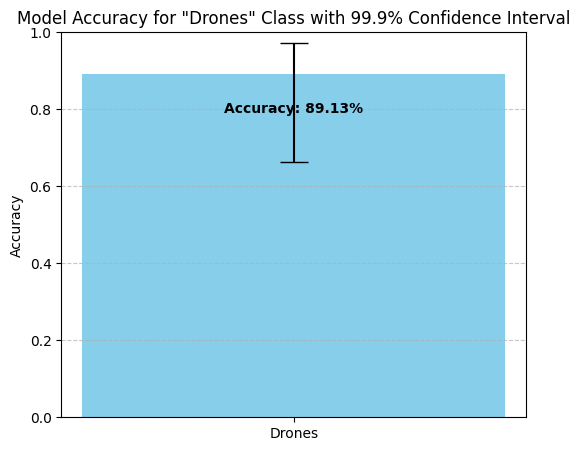

In [15]:
import matplotlib.pyplot as plt

error = [[p - lower_bound], [upper_bound - p]]

plt.figure(figsize=(6, 5))
plt.bar(
    x=[class_name],
    height=[p],
    color='skyblue',
    yerr=error,
    capsize=10
)

plt.ylabel('Accuracy')
plt.title(f'Model Accuracy for "{class_name}" Class with 99.9% Confidence Interval')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.text(0, p - 0.1, f'Accuracy: {p:.2%}', ha='center', color='black', weight='bold')

plt.show()